[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/contents/gray_SQ/gray_SQ_deadzone.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/contents/gray_SQ/gray_SQ_deadzone.ipynb)

# Gray-scale Image compression Using an Uniform Midtread Scalar Quantizer with Deadzone and PNG

**Deadzone quantizers should be applied to signed data centered at 0!**

Notice that if the input image is unsigned, does not make sense to use a deadzone quantizer because we need to center the pixel intensity values on 0 by substracting -128 (supposing 8 bits/component). This means that the values close to 128 (the closeness depends on the quantization step size) will be more severely quantized by the deadzone. 

In [1]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    #plt.rcParams['text.usetex'] = True
    #plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
%matplotlib inline

In [9]:
try:
    from skimage import io
except:
    !pip install scikit-image
    from skimage import io

In [15]:
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

In [3]:
try:
    from scalar_quantization.deadzone_quantization import Deadzone_Quantizer as Quantizer                          
except:
    !pip install "scalar_quantization @ git+https://github.com/vicente-gonzalez-ruiz/scalar_quantization"
    from scalar_quantization.deadzone_quantization import Deadzone_Quantizer as Quantizer
    from scalar_quantization.deadzone_quantization import name as quantizer_name

In [22]:
try:
    from information_theory.information import entropy                          
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    from information_theory.information import entropy
    from information_theory.distortion import MSE
    from information_theory.distortion import SSIM

  Cloning https://github.com/vicente-gonzalez-ruiz/information_theory to /tmp/pip-install-gms0sn1o/information-theory_e13b36afde20412f9582196aec0e29c4
  Running command git clone --filter=blob:none --quiet https://github.com/vicente-gonzalez-ruiz/information_theory /tmp/pip-install-gms0sn1o/information-theory_e13b36afde20412f9582196aec0e29c4
  Resolved https://github.com/vicente-gonzalez-ruiz/information_theory to commit 2da7ce4628ef7a4b8dbb7ff51122c3cc53f85eba
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


ModuleNotFoundError: No module named 'information_theory'

In [ ]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

In [ ]:
%%bash
if [ -d "$HOME/repos/scalar_quantization" ]; then
    cd $HOME/repos/scalar_quantization
    echo "$HOME/repos/scalar_quantization ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/scalar_quantization.git
fi

In [ ]:
%%bash
if [ -d "$HOME/repos/MRVC" ]; then
    cd $HOME/repos/MRVC
    echo "$HOME/repos/MRVC ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/Sistemas-Multimedia/MRVC.git
fi

In [ ]:
#%%bash
#if [ -d "$HOME/repos/image_IO" ]; then
#    cd $HOME/repos/image_IO
#    echo "$HOME/repos/image_IO ... "
#    git pull 
#else
#    cd $HOME/repos
#    git clone https://github.com/vicente-gonzalez-ruiz/image_IO.git
#fi
try:
    import image_IO
except:
    !pip install 'image_IO @ git+https://github.com/vicente-gonzalez-ruiz/image_IO'

In [ ]:
%%bash
if [ -d "$HOME/repos/information_theory" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/information_theory ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/information_theory.git
fi

In [ ]:
#!ln -sf ~/MRVC/src/logging_config.py .
!ln -sf ~/repos/scalar_quantization/quantization.py .
!ln -sf ~/repos/scalar_quantization/deadzone_quantization.py .
!ln -sf ~/repos/information_theory/distortion.py .
!ln -sf ~/repos/information_theory/information.py .
!ln -sf ~/repos/image_IO/image_1.py .
!ln -sf ~/repos/image_IO/logging_config.py .

In [ ]:
try:
    import scipy
except:
    !pip install scipy

In [ ]:
try:
    import cv2
except:
    !pip install opencv-python
    !pip install opencv-python-headless # Binder compatibility
#    import cv2

try:
    import skimage
except:
    !pip install scikit-image
    import skimage
    
try:
    import colored
except:
    !pip install colored
#    import colored

import pylab
import math
from scipy import signal
import cv2
import os
import deadzone_quantization as quantization
import distortion
#import image_3 as RGB_image
#import image_1 as gray_image
from image_IO import image_1 as gray_image
import colored
import information

## Configuration

In [10]:
# Prefix of the gray-scale image to be quantized.

#home = os.environ["HOME"]
#fn = home + "/repos/MRVC/images/lena_bw/"
#fn = home + "/repos/MRVC/images/Hommer_bw/"
#fn = home + "/repos/MRVC/images/barb_bw/"
#fn = home + "/repos/MRVC/images/boat_bw/"
#fn = home + "/repos/MRVC/images/crowd_bw/"
#fn = home + "/repos/MRVC/images/fear_bw/"
#fn = home + "/repos/MRVC/images/goldhill_bw/"
#fn = home + "/repos/MRVC/images/zelda_bw/"
#!ls -l {fn}
fn = "http://www.hpca.ual.es/~vruiz/images/lena.png"

In [ ]:
quantizer = quantization.Deadzone_Quantizer

#RGB_image.write = RGB_image.debug_write # faster
#RGB_image.write = RGB_image.write # higher compression

gray_image.write = gray_image.debug_write # faster
#gray_image.write = gray_image.write # higher compression

## Bins and representation levels

In [4]:
QSS = 64 # Quantization Step Size
Q = Quantizer(Q_step=QSS, min_val=-128, max_val=127)
print("decision_levels =", Q.get_decision_levels())
print("representation_levels =", Q.get_representation_levels())

decision_levels = [-128.  -64.   63.  127.]
representation_levels = [-160.  -96.    0.   96.]


## Quantization indexes and their reconstructions

In [6]:
Q.encode(Q.get_representation_levels())

array([-2, -1,  0,  1])

In [8]:
Q.decode(Q.encode(Q.get_representation_levels()))

array([-160.,  -96.,    0.,   96.])

As it can be seen:
1. We can produce the output 0 (midtread).
2. The representation levels are in the middle point of the bins.
3. The deadzone is centered at 0 and the width of the corresponding bin is $2\Delta$.

## Read the image and show it

In [13]:
#img = gray_image.read(fn, 0)
img = io.imread(fn)
img.dtype

dtype('uint8')

255 1


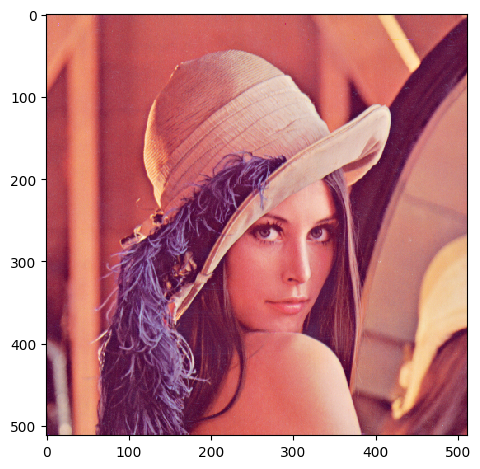

In [14]:
print(img.max(), img.min())
#gray_image.show(img, fn + "000.png")
io.imshow(img)
plt.show()

## Show the histogram

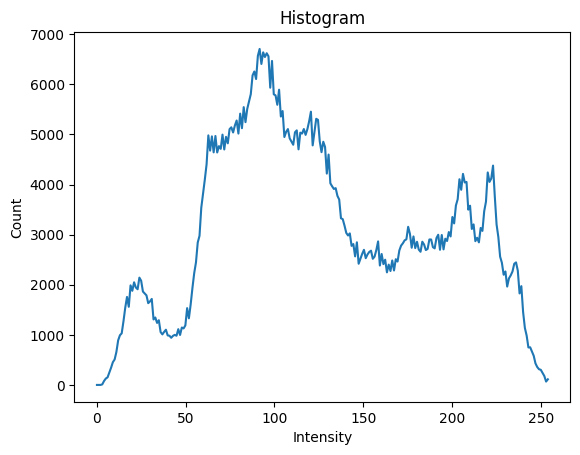

In [16]:
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))

plt.figure()
plt.title("Histogram")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.plot(bin_edges[0:-1], histogram)

## Shift the pixel intensities

The deadzone is centered at input 0 and in the images that we are using the pixel values are always positive, therefore, to see the impact of the deadzone, this should be centered in the histogram. However, notice that depending on the histogram of the image, this step could not be good for increasing the compression ratio because the samples values that fall in the deadzone are going to be quantized with a higher noise (exactly twice). In general, the deadzone should be placed where the SNR (Signal to Noise Ratio) is smaller, and this tend to happen where the values are smaller (supposing that the noise does not depend on the intensity of the signal).

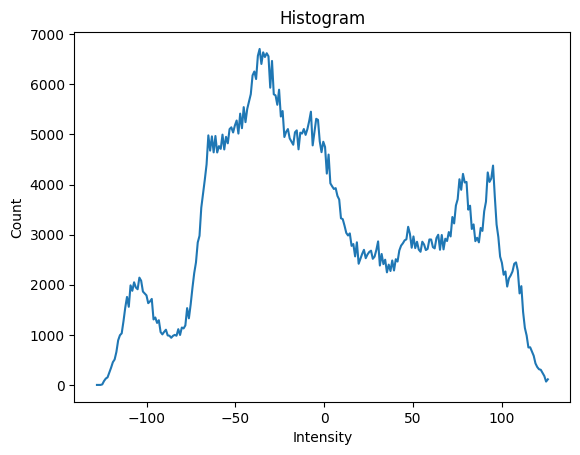

In [17]:
img_128 = img.astype(np.int16) - 128
histogram, bin_edges = np.histogram(img_128, bins=256, range=(-128, 127))

plt.figure()
plt.title("Histogram")
plt.xlabel("Intensity")
plt.ylabel("Count")
#plt.xlim([0.0, 1.0])  # <- named arguments do not work here
plt.plot(bin_edges[0:-1], histogram)  

## Visualize a quantization result

In [18]:
QSS = 16 # Quantization Step Size
Q = Quantizer(Q_step=QSS, min_val=-128, max_val=127)
y, k = Q.encode_and_decode(img_128)
print("Used quantization indexes:", np.unique(k))
io.show(k + 128, f"{quantizer_name} $\\Delta={QSS}$ (quantization indexes + 128)")
io.show_normalized(k, f"{quantizer_name} $\\Delta={QSS}$ (normalized quantization indexes)")
io.show(y + 128, f"{quantizer_name} $\\Delta={QSS}$ (dequantized image)")
plt.show()
print("MSE =", distortion.MSE(img, y))
print("SSIM =", distortion.SSIM(img, y))
print("entropy =", information.entropy(k.flatten()))

Used quantization indexes: [-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7]


NameError: name 'quantization' is not defined

## RD curve

In [ ]:
def RD_curve(img_128, Q_steps, quantizer):
    points = []
    for Q_step in Q_steps:
        Q = quantizer(Q_step=Q_step, min_val=-128, max_val=127)
        y, k = Q.quan_dequan(img_128)
        k += 128 # Only positive components can be written in a PNG file
        k = k.astype(np.uint8)
        print(np.max(k), np.min(k), k.dtype)
        print("\nQuantization indexes: ", np.unique(k))
        rate = gray_image.write(k, "/tmp/" + str(Q_step) + '_', 0)*8/(k.shape[0]*k.shape[1])
        #rate = compute_BPP(k, "/tmp/" + str(Q_step) + '_')
        _distortion = distortion.RMSE(img_128, y)
        points.append((rate, _distortion))
        print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
        plt.title(f"$\Delta={Q_step}$ max={y.max()} min={y.min()}")
        plt.imshow(y + 128, cmap=plt.cm.gray, vmin=0, vmax=256)
        plt.show()
    return points

def RD_curve_(_img, Q_steps, quantizer):
    img = _img.copy().astype(np.int16)
    img -= 128
    points = []
    for Q_step in Q_steps:
        Q = quantizer(Q_step=Q_step, min_val=-128, max_val=127)
        y, k = Q.quan_dequan(img)
        k += 128
        print(np.max(k), np.min(k), k.dtype)
        print("\nQuantization indexes: ", np.unique(k))
        k = k.astype(np.uint8) # Only positive components can be written in a PNG file
        rate = gray_image.write(k, "/tmp/" + str(Q_step) + '_', 0)*8/(k.shape[0]*k.shape[1])
        #rate = compute_BPP(k, "/tmp/" + str(Q_step) + '_')
        _distortion = distortion.RMSE(img, y)
        points.append((rate, _distortion))
        print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
        plt.title(f"$\Delta={Q_step}$ max={y.max()} min={y.min()}")
        plt.imshow(y+128, cmap=plt.cm.gray, vmin=0, vmax=256)
        plt.show()
    return points

def RD_curve2(_img, Q_steps, quantizer):
    img = _img.copy()
    points = []
    for Q_step in Q_steps:
        Q = quantizer(Q_step=Q_step, min_val=0, max_val=255)
        y, k = Q.quan_dequan(img)
        print("\nQuantization indexes: ", np.unique(k))
        print("Reconstruction values: ", np.unique(y))
        k = k.astype(np.uint8)
        rate = gray_image.write(k, "/tmp/" + str(Q_step) + '_', 0)*8/(k.shape[0]*k.shape[1])
        #rate = compute_BPP(k, "/tmp/" + str(Q_step) + '_')
        _distortion = distortion.RMSE(img, y)
        points.append((rate, _distortion))
        print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
        plt.title(f"$\Delta={Q_step}$ max={y.max()} min={y.min()}")
        plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=256)
        plt.show()
    return points

Q_steps = [2**i for i in range(7, -1, -1)] # Quantization steps (simulating bit-plane encoding)
#Q_steps = [i for i in range(128, 16, -2)]
print(Q_steps)

RD_points = RD_curve(img_128, Q_steps, quantizer)
#RD_points_ = RD_curve_(img, Q_steps, quantizer)
#RD_points2 = RD_curve2(img, Q_steps, quantizer)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker='x', label=fn, linestyle="dotted")
pylab.title(f"Rate/Distortion Performance ({quantization.name})")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

In [ ]:
with open("gray_deadzone_SQ.txt", 'w') as f:
    for item in RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

## What happens if we increase the granuality?
Let's see the effect of using a finer quantization step (size).

In [ ]:
Q_steps = range(128, 0, -1)

In [ ]:
def _(a, cmap, vmin, vmax):
    pass
plt.show = print
plt.imshow = _
RD_points_finer = RD_curve(img_128, Q_steps, quantizer)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points), c='m', marker='x', label=f"Using powers of 2", linestyle="dotted")
pylab.scatter(*zip(*RD_points_finer), c='g', marker='o', label=f"Using more quantization steps", s=5)
pylab.title(f"Rate/Distortion Performance ({quantization.name}, {fn})")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
pylab.legend(loc='upper right')
pylab.show()

In [ ]:
# Ignore the rest.

import time
while True:
    time.sleep(1)